## Tomato Disease Classification - ConvNext

In [1]:
import os
import math
import random

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset_dir = "/kaggle/input/plant-diseases-training-dataset/data"
test_dir = "/kaggle/input/plant-disease-test-dataset/data"

classes = ['Apple___healthy', 'Apple___rust', 'Bell_pepper___bacterial_spot', 
           'Bell_pepper___healthy', 'Tomato___septoria_leaf_spot', 'Tomato___healthy',
          'Grape___black_rot', 'Grape___healthy']

input_size = (224, 224)

batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    channel_shift_range=10,
    validation_split=0.2
)



train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    classes=classes
)

validation_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    classes=classes,
    shuffle=False
)

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_data_gen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes,
    shuffle=False
)

Found 9708 images belonging to 8 classes.
Found 2425 images belonging to 8 classes.
Found 964 images belonging to 8 classes.


Random Samples from Train Dataset:


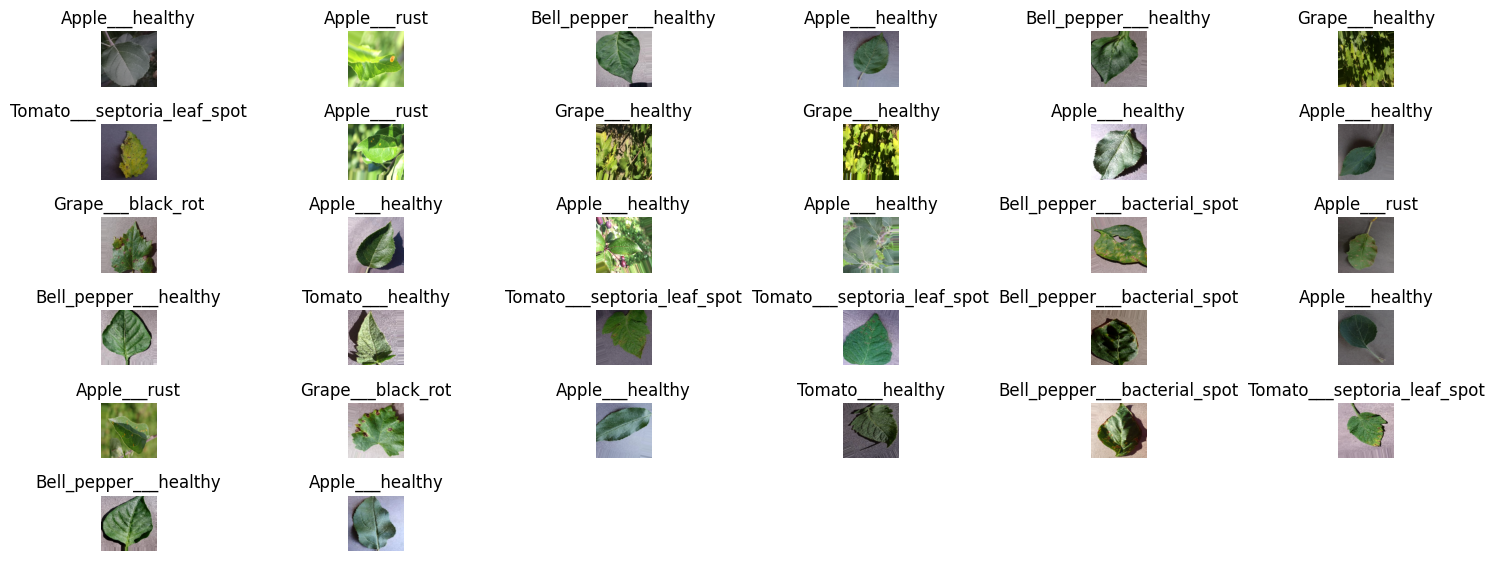

Random Samples from Validation Dataset:


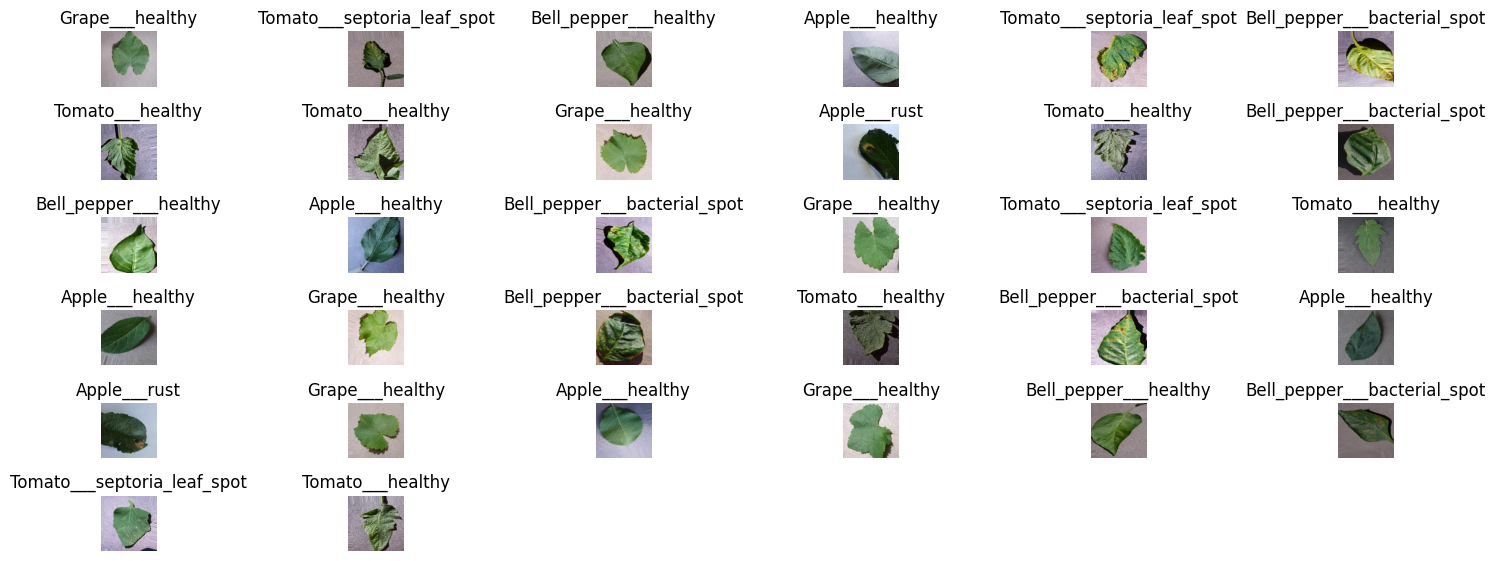

Random Samples from Test Dataset:


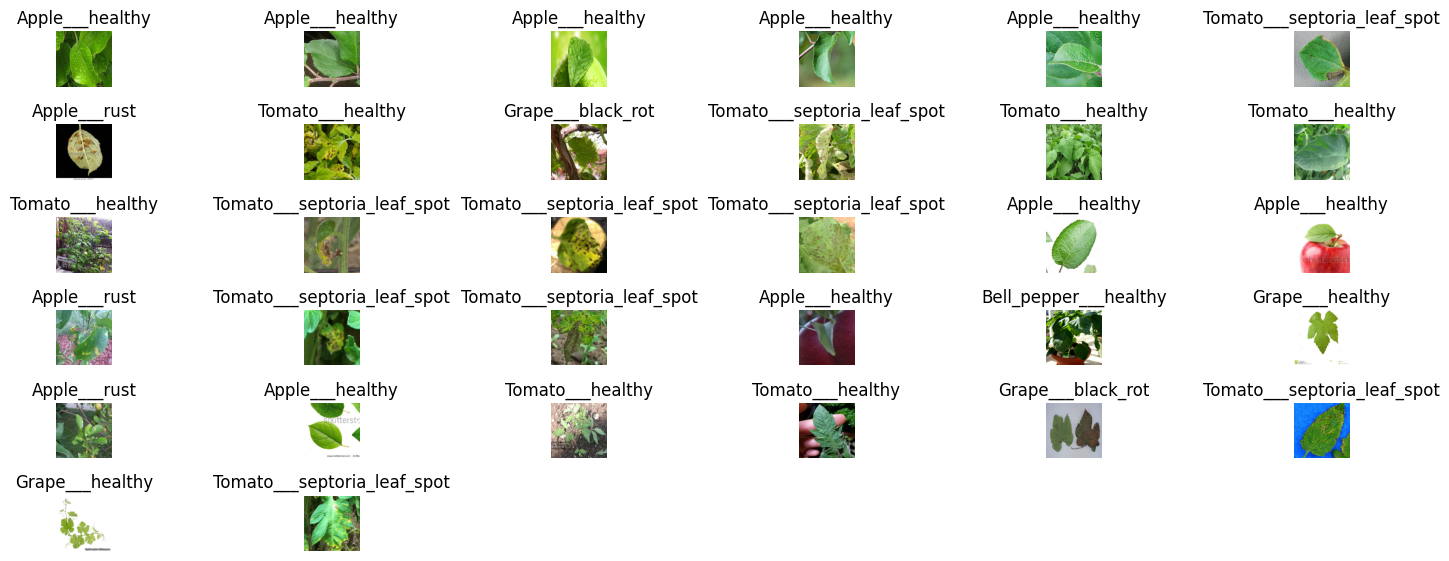

In [3]:
def display_random_samples(data_generator, num_samples=96):
    num_cols = 6
    num_rows = math.ceil(num_samples / num_cols)
    plt.figure(figsize=(15, 15))
    
    # Shuffle the data generator
    data_generator.shuffle = True
    
    for i, (X_batch, y_batch) in enumerate(data_generator):
        for j in range(min(num_samples, len(X_batch))):
            plt.subplot(num_rows, num_cols, j+1)
            plt.imshow(X_batch[j])
            plt.title(f"{list(data_generator.class_indices.keys())[int(y_batch[j])]}")
            plt.axis("off")
        if i >= (num_samples / batch_size) - 1:
            break  # Stop after displaying the required number of samples
    plt.tight_layout()
    plt.show()

# Display random samples from train dataset
print("Random Samples from Train Dataset:")
display_random_samples(train_ds)

# Display random samples from validation dataset
print("Random Samples from Validation Dataset:")
display_random_samples(validation_ds)

# Display random samples from test dataset
print("Random Samples from Test Dataset:")
display_random_samples(test_ds)

In [4]:
train_class_labels = list(train_ds.class_indices.keys())
train_class_labels

['Apple___healthy',
 'Apple___rust',
 'Bell_pepper___bacterial_spot',
 'Bell_pepper___healthy',
 'Tomato___septoria_leaf_spot',
 'Tomato___healthy',
 'Grape___black_rot',
 'Grape___healthy']

In [5]:
num_classes = len(train_class_labels)
num_classes

8

In [6]:
# Load the pre-trained EfficientNetV2S model without the top classification layer
# base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model = ConvNeXtBase(
    model_name='convnext_base',
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=8,
    classifier_activation='softmax'
)

# Freeze layers up to a certain point
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last four layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))


350926856/350926856 [==============================] - 15s 0us/step


In [7]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

true_labels = validation_ds.classes
class_indices = np.unique(true_labels)

class_weights = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(true_labels), 
    y = true_labels)
class_weights = dict(enumerate(class_weights))


In [10]:
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/50
304/304 [==============================] - 351s 1s/step - loss: 1.6107 - accuracy: 0.3436 - val_loss: 1.3832 - val_accuracy: 0.4594
Epoch 2/50
304/304 [==============================] - 220s 724ms/step - loss: 1.0557 - accuracy: 0.5567 - val_loss: 1.1619 - val_accuracy: 0.5790
Epoch 3/50
304/304 [==============================] - 223s 732ms/step - loss: 0.9184 - accuracy: 0.6260 - val_loss: 0.9634 - val_accuracy: 0.6478
Epoch 4/50
304/304 [==============================] - 222s 728ms/step - loss: 0.8486 - accuracy: 0.6620 - val_loss: 0.9460 - val_accuracy: 0.6487
Epoch 5/50
304/304 [==============================] - 217s 714ms/step - loss: 0.8017 - accuracy: 0.6857 - val_loss: 0.9765 - val_accuracy: 0.6639
Epoch 6/50
304/304 [==============================] - 220s 724ms/step - loss: 0.7480 - accuracy: 0.7041 - val_loss: 0.8470 - val_accuracy: 0.6808
Epoch 7/50
304/304 [==============================] - 218s 716ms/step - loss: 0.7417 - accuracy: 0.7067 - val_loss: 0.8269 - va

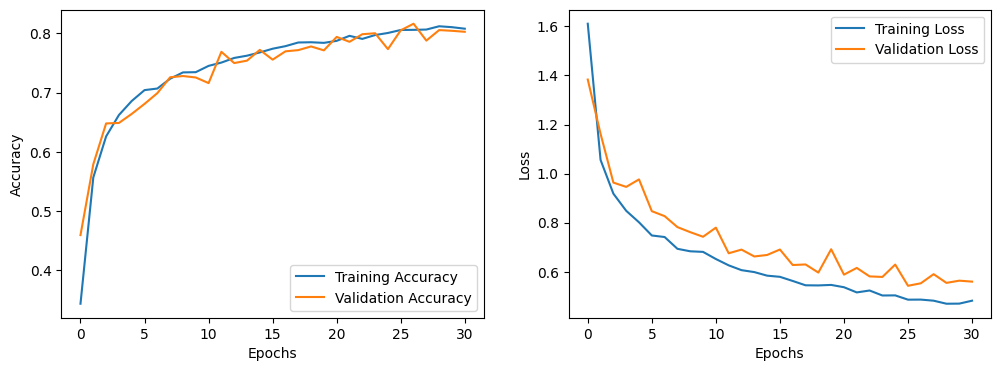

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
predictions = model.predict(validation_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = validation_ds.classes

print(classification_report(true_labels, predicted_labels, sample_weight=np.array([class_weights[i] for i in true_labels])))

76/76 [==============================] - 41s 489ms/step
              precision    recall  f1-score   support

           0       0.14      0.19      0.16 303.12500000000097
           1       0.12      0.09      0.11 303.1250000000013
           2       0.15      0.10      0.12 303.1249999999999
           3       0.12      0.13      0.12 303.1249999999988
           4       0.12      0.13      0.13 303.1249999999972
           5       0.13      0.17      0.15 303.12500000000045
           6       0.11      0.15      0.13 303.1250000000008
           7       0.07      0.03      0.04 303.1249999999992

    accuracy                           0.12 2424.9999999999986
   macro avg       0.12      0.12      0.12 2424.9999999999986
weighted avg       0.12      0.12      0.12 2424.9999999999986



### Testing

In [13]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_ds.classes

print(classification_report(true_labels, predicted_labels))

31/31 [==============================] - 26s 837ms/step
              precision    recall  f1-score   support

           0       0.19      0.22      0.20       204
           1       0.07      0.21      0.10        80
           2       0.03      0.04      0.03        57
           3       0.12      0.05      0.07        56
           4       0.43      0.15      0.23       385
           5       0.07      0.05      0.06        62
           6       0.07      0.12      0.09        57
           7       0.05      0.08      0.06        63

    accuracy                           0.15       964
   macro avg       0.13      0.12      0.11       964
weighted avg       0.24      0.15      0.16       964



In [14]:
model.save("efficientnetv2s_fine_tuned.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
